<a href="https://colab.research.google.com/github/dvircohen0/projects/blob/main/cats-dogs-YAMnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow_io
!pip install unsilence

In [3]:
import os
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio
import seaborn as sns
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from google.colab import files 

In [ ]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mmoreaux/audio-cats-and-dogs
!unzip "/content/audio-cats-and-dogs.zip"

**Loading YAMNet from TensorFlow Hub**

Using YAMNet from Tensorflow Hub to extract the embeddings from the sound files.

In [6]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

Util functions for loading audio files and ensure the correct sample rate

In [7]:
@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

Loading the class names that YAMNet is able to recognize. The mapping file is present at yamnet_model.class_map_path(), in the csv format.

In [8]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


 **Explore the data**
 
The dataset consists in many "wav" files for both the cat and dog classes : cat has 164 WAV files to which corresponds 1323 sec of audio dog has 113 WAV files to which corresponds 598 sec of audio All the WAV files contains 16KHz audio and have variable length.

In [10]:
data_csv = '/content/train_test_split.csv'
base_data_path = '/content/cats_dogs'
my_classes = ['cat', 'dog']

train_dogs_files = '/content/cats_dogs/train/dog/' +\
pd.DataFrame(os.listdir("/content/cats_dogs/train/dog/"),columns=["file_name"])
train_dogs_labels = pd.DataFrame(np.asarray(np.ones(len(train_dogs_files))).astype(np.int32),columns=["label"])

test_dogs_files = '/content/cats_dogs/test/test/' +\
pd.DataFrame(os.listdir("/content/cats_dogs/test/test/"),columns=["file_name"])
test_dogs_labels = pd.DataFrame(np.asarray(np.ones(len(test_dogs_files))).astype(np.int32),columns=["label"])

train_cats_files = '/content/cats_dogs/train/cat/' +\
pd.DataFrame(os.listdir("/content/cats_dogs/train/cat/"),columns=["file_name"])
train_cats_labels = pd.DataFrame(np.asarray(np.zeros(len(train_cats_files))).astype(np.int32),columns=["label"]) 

test_cats_files = '/content/cats_dogs/test/cats/' +\
pd.DataFrame(os.listdir("/content/cats_dogs/test/cats/"),columns=["file_name"])
test_cats_labels = pd.DataFrame(np.asarray(np.zeros(len(test_cats_files))).astype(np.int32),columns=["label"])

data=pd.concat([train_dogs_files,train_cats_files,test_dogs_files,test_cats_files],ignore_index=True).squeeze()
labels=pd.concat([train_dogs_labels,train_cats_labels,test_dogs_labels,test_cats_labels],ignore_index=True).squeeze()

complete=pd.concat([data,labels], axis=1)



Removing silence parts from the WAV files

In [11]:
files = complete["file_name"].values
for file in tqdm(files, desc="removing silence..."):
    os.system("unsilence [{}] [{}]".format(file,file))

Split the data proportionally into train tset validation

In [12]:
X=complete["file_name"].values
y=complete["label"].values

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.15, random_state=2, stratify=y)
trainX, valX, trainy, valy = train_test_split(trainX, trainy, test_size=0.21, random_state=2, stratify=trainy)
    
train_0, train_1 = len(trainy[trainy==0]), len(trainy[trainy==1])
test_0, test_1 = len(testy[testy==0]), len(testy[testy==1])
val_0, val_1 = len(valy[valy==0]), len(valy[valy==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d, Val: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1, val_0, val_1))

folds=[]
for file in X:
    if file in testX:
        folds.append("testX")
    elif file in valX:
        folds.append("valX")
    else: folds.append("trainX")
        
        
fold_names = pd.DataFrame(folds,columns=["fold"]).squeeze()
complete=pd.concat([complete,fold_names], axis=1)
complete = shuffle(complete)
complete.head()
  

>Train: 0=109, 1=76, Test: 0=25, 1=17, Val: 0=30, 1=20


,file_name,label,fold
84,/content/cats_dogs/train/dog/dog_barking_95.wav,1,trainX
220,/content/cats_dogs/test/test/dog_barking_66.wav,1,trainX
241,/content/cats_dogs/test/cats/cat_90.wav,0,trainX
70,/content/cats_dogs/train/dog/dog_barking_85.wav,1,valX
216,/content/cats_dogs/test/test/dog_barking_15.wav,1,trainX


**Load the audio files and retrieve embeddings**

apply the load_wav_16k_mono and prepare the wav data for the model.

When extracting embeddings from the wav data, you get an array of shape (N, 1024) where N is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

The model will use each frame as one input so its needed to to create a new column that has one frame per row, and also need to expand the labels and fold column to proper reflect these new rows.

In [13]:
main_ds = tf.data.Dataset.from_tensor_slices((data, labels,folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [14]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

In [15]:
main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [16]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

**Split the data**

using the fold column to split the dataset into train, validation and test.

The fold values are so that files from the same original wav file are keep on the same split.

The last step is to remove the fold column from the dataset since we're not going to use it anymore on the training process.

In [17]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold == "trainX")
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == "valX")
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == "testX")

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

**Create the model**

Define a Sequential Model to start with -- one hiden layer and 2 outputs to recognize cats and dogs.

In [18]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [19]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=12,
                                            restore_best_weights=True)

In [20]:
history = my_model.fit(train_ds,
                       epochs=100,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/100
80/80 [==============================] - 29s 200ms/step - loss: 0.2973 - accuracy: 0.8564 - val_loss: 0.2329 - val_accuracy: 0.9097
Epoch 2/100
80/80 [==============================] - 0s 5ms/step - loss: 0.2399 - accuracy: 0.9496 - val_loss: 0.2227 - val_accuracy: 0.9112
Epoch 3/100
80/80 [==============================] - 0s 6ms/step - loss: 0.1135 - accuracy: 0.9764 - val_loss: 0.2766 - val_accuracy: 0.9054
Epoch 4/100
80/80 [==============================] - 0s 6ms/step - loss: 0.1284 - accuracy: 0.9755 - val_loss: 0.3789 - val_accuracy: 0.8754
Epoch 5/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0705 - accuracy: 0.9838 - val_loss: 0.5692 - val_accuracy: 0.8897
Epoch 6/100
80/80 [==============================] - 0s 5ms/step - loss: 0.0835 - accuracy: 0.9837 - val_loss: 0.3406 - val_accuracy: 0.8997
Epoch 7/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0441 - accuracy: 0.9884 - val_loss: 0.3617 - val_accuracy: 0.9026
Epoch 8/10

In [21]:
loss, accuracy = my_model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

19/19 [==============================] - 0s 5ms/step - loss: 0.3325 - accuracy: 0.9497
Loss:  0.33250924944877625
Accuracy:  0.9496644139289856


checking the training and validation loss curves to see how the model has improved during training.

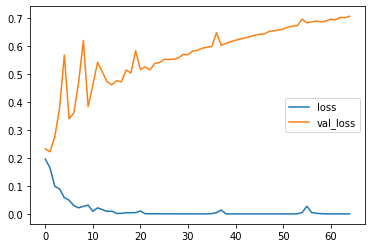

In [22]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

**Save a model that can directly take a wav file as input**

The model works when it gets the embeddings as input.
In a real situation we want to give it the sound data directly.
To do that you will combine YAMNet with the new model into one single model that can be exported for other applications.
To make it easier to use the model's result, the final layer will be a reduce_mean operation. 

In [23]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


saved_model_path = './dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)


#Load the saved model to verify that it works as expected.
reloaded_model = tf.saved_model.load(saved_model_path)

INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


compare the model to YAMNet on the test dataset.

/content/cats_dogs/test/test/dog_barking_34.wav
Waveform values: [ 0.0000000e+00 -1.7656580e-10  3.5047668e-10 ...  1.4884948e-02
  2.0031421e-02  1.9787556e-02]


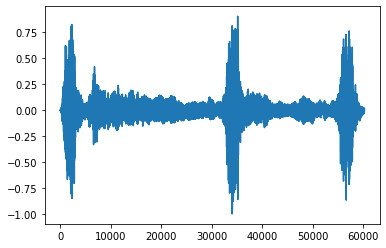

In [24]:
test_pd = complete.loc[complete['fold'] == "testX"]
row = test_pd.sample(1)
filename = row['file_name'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [25]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {infered_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.argmax(reloaded_results)
your_infered_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_infered_class} ({your_top_score})')

[YAMNet] The main sound is: Animal (0.7227101922035217)
[Your model] The main sound is: dog (1.0)


**Evaluate test set performance**

running the model on the test set and check performance.

In [ ]:
test_audio = []
test_labels = []

for _, row in test_pd.iterrows():
    test_audio.append(load_wav_16k_mono(row["file_name"]))
    test_labels.append(row['label'])
    
y_pred=[]
for test_sound in test_audio:
    y_pred.append(reloaded_model(test_sound))
y_pred = np.argmax(y_pred, axis=1)

y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

**Display a confusion matrix**

A confusion matrix is helpful to see how well the model did on each of the classes in the test set.

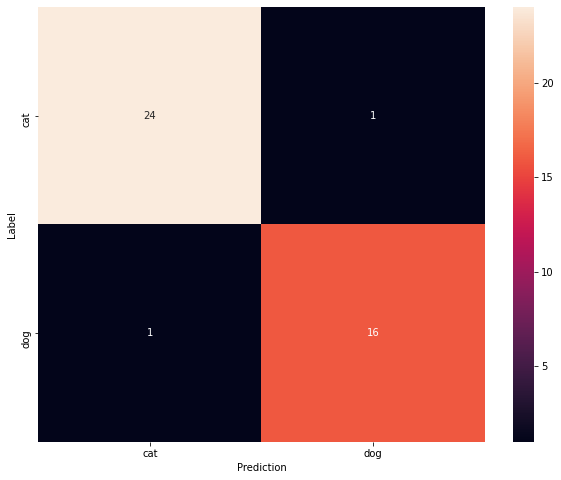

In [27]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=my_classes, yticklabels=my_classes, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()